# FMCW Intro - Grouping

You can open this workbook in Google Colab to experiment with mmWrt 
[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/matt-chv/mmWrt/blob/main/docs/Grouping.ipynb)

Below is an intro to mmWrt for simple targets position estimation

For a generic introduction to mmWave sensors:
[Watch Here](https://www.youtube.com/watch?v=XJ6JhB8wOPU)

## The problem

As distance estimation is based on FFT, spectral leakage even after CFAR may lead to detection of too many targets.

Changing synthetic target distances in order to make this more visible in the below code

## The solution

Pass the index of FFT bin which are over the CFAR threshold to a peak_grouping function which groups them.

Multiple grouping algorithms are possible:
    * 1D: Adjacent grouping to lead or tail, or interpolation grouping to find the more likely position of the point target 

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install mmWrt

In [1]:
from os.path import abspath, join, pardir
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from numpy import where, expand_dims

# uncomment below if the notebook is launched from project's root folder
# dp = abspath(join(".",pardir))
# sys.path.insert(0, dp)


from mmWrt.Raytracing import rt_points  # noqa: E402
from mmWrt.Scene import Radar, Transmitter, Receiver, Target  # noqa: E402
from mmWrt import RadarSignalProcessing as rsp  # noqa: E402

## Exposing the problem

synthetic targets [(2, 0, 0), (5, 0, 0)]
found targets [(1.9617706237424548, 0, 0), (2.112676056338028, 0, 0), (4.979879275653924, 0, 0), (5.130784708249497, 0, 0)]
error is 2.9255533199195174


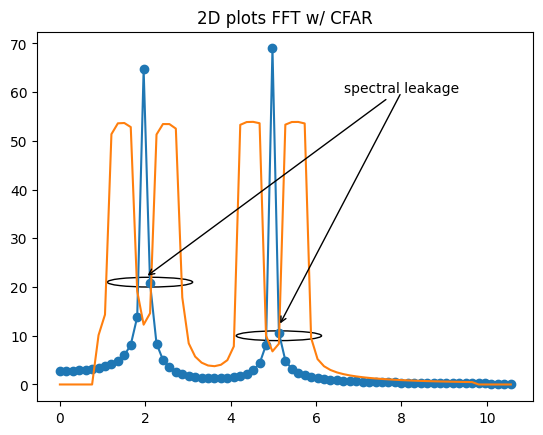

In [20]:
c = 3e8

debug_ON = True
test = 0
radar = Radar(transmitter=Transmitter(bw=1e9, slope=70e8),
              receiver=Receiver(fs=1e3, max_adc_buffer_size=256,
                                debug=debug_ON), debug=debug_ON)

target1 = Target(2)
target2 = Target(5, 0, 0, vx=lambda t: 2*t+0)
# below is also an equivalent definition of target2
# as at t=0 the position will be x0=2+3=5
# target2 = Target(2, 0, 0, vx=lambda t: 2*t+3)
targets = [target1, target2]

bb = rt_points(radar, targets, debug=debug_ON)
Distances, range_profile = rsp.range_fft(bb)
ca_cfar = rsp.cfar_ca_1d(range_profile)

mag_r = abs(range_profile)
mag_c = abs(ca_cfar)
# little hack to remove small FFT ripples : mag_r> 5
target_filter = ((mag_r > mag_c) & (mag_r > 5))

index_peaks = where(target_filter)[0]
# grouped_peaks = rsp.peak_grouping_1d(index_peaks)

found_targets = [Target(Distances[i]) for i in index_peaks]
error = rsp.error([target1, target2], found_targets)
print("synthetic targets", [t.pos() for t in targets])
print("found targets", [t.pos() for t in found_targets])
print("error is", error)

# 2D representation of the FFT and CFAR
# plot on X,Y axis the FFT and CFAR
figure, axes = plt.subplots()
plt.plot(Distances, mag_r, '-o')
plt.plot(Distances, mag_c)
plt.title("2D plots FFT w/ CFAR")

# Add illustration of spectral leakage
leakage_1 = plt.Circle( (2.11, 21 ), 1, fill=False)
leakage_2 = plt.Circle( (5.13, 10 ), 1, fill=False)
 
axes.add_artist(leakage_1)
axes.add_artist(leakage_2)
plt.annotate("spectral leakage", xy=(2, 22),xytext=(8,60),
             horizontalalignment="center",
             # Custom arrow
             arrowprops=dict(arrowstyle='->',lw=1)
             )

plt.annotate("", xy=(5.13, 12),xytext=(8,60),
             horizontalalignment="center",
             # Custom arrow
             arrowprops=dict(arrowstyle='->',lw=1)
             )

plt.show()

## The solution: peak grouping

In order to reduce the error, it is necessasry to proceed to peak grouping 

below code shows how to do it by calling `peak_grouping_1d`

The result can be seen in that the error (distance between synthetic targets and found targets) is reduced  <div style="color:red">from 2.9 to 0.05</div>

In [23]:
index_peaks = where(target_filter)[0]
grouped_peaks = rsp.peak_grouping_1d(index_peaks)

found_targets = [Target(Distances[i]) for i in grouped_peaks]
error_grouped = rsp.error([target1, target2], found_targets)
print("synthetic targets", [t.pos() for t in targets])
print("found targets", [t.pos() for t in found_targets])
print(f"RMS error reduced from: {error} to: {error_grouped}")



synthetic targets [(2, 0, 0), (5, 0, 0)]
found targets [(1.9617706237424548, 0, 0), (4.979879275653924, 0, 0)]
RMS error reduced from: 2.9255533199195174 to: 0.05835010060362111
